# Crime Hotspot Detection - Clustering Validation

This notebook performs data validation and clustering readiness assessment for crime hotspot identification. It validates the presence of natural clusters in the data.

## Key Objectives
- Assess clustering tendency using Hopkins statistic
- Validate data integrity and completeness
- Ensure data is suitable for spatial-temporal hotspot analysis

**Note:**
- This notebook focuses on pre-clustering validation to ensure meaningful cluster analysis
- Statistical testing confirms data structure is suitable for hotspot detection

# Setup

Import essential libraries for data validation, clustering tendency assessment, and visualization.

### Import libraries

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import List, Dict, Any, Tuple, Union
import time

# Data validation and clustering libraries
from scipy.stats import uniform
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Statistical testing
from scipy.stats import kstest, shapiro
from scipy.spatial.distance import pdist, squareform

import random

random.seed(42)
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("Libraries imported and random seeds set.")

Libraries imported and random seeds set.


## Path Definition

Define paths for loading the preprocessed crime dataset and saving validation results.

In [26]:
import os

base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "JupyterOutputs"))
feature_engineered_file_path = os.path.join(base_dir, "Final", "final_crime_data.csv")
save_dir = os.path.join(base_dir, "Clustering")
os.makedirs(save_dir, exist_ok=True)

print(f"Base directory: {base_dir}")
print(f"Feature engineered file path: {feature_engineered_file_path}")
print(f"Save directory: {save_dir}")

Base directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs
Feature engineered file path: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Final\final_crime_data.csv
Save directory: c:\UNIVERSITA MAG\Data mining and Machine learning\Progetto\crime-analyzer\JupyterOutputs\Clustering


# Data Loading & Validation

Load the preprocessed crime dataset and perform initial validation of data integrity and completeness.

### Load and validate dataset

In [27]:
def load_and_validate_data(file_path: str) -> pd.DataFrame:
    """
    Load crime dataset and perform initial validation.
    
    Args:
        file_path: Path to the preprocessed crime data CSV file
        
    Returns:
        DataFrame: Loaded and validated crime data
    """
    print("=== Loading Crime Dataset ===")
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found at: {file_path}")
    
    df = pd.read_csv(file_path)
    print(f"Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")
    
    return df

# Load the dataset
df = load_and_validate_data(feature_engineered_file_path)

=== Loading Crime Dataset ===
Loaded data: 2493835 rows, 44 columns


### Data integrity assessment

In [28]:
print("=== Data Integrity Assessment ===")

# Basic data info
print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns: {df.columns.tolist()}")

# Data types overview
print("\n=== Data Types Overview ===")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"{dtype}: {count} columns")

# Missing values analysis
print("\n=== Missing Values Analysis ===")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if len(missing_data) > 0:
    print(f"Columns with missing values: {len(missing_data)}")
    for col, missing_count in missing_data.head(10).items():
        missing_pct = (missing_count / len(df)) * 100
        print(f"  {col}: {missing_count} ({missing_pct:.2f}%)")
else:
    print("No missing values found in the dataset.")

# Duplicate rows check
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")

=== Data Integrity Assessment ===
Dataset shape: (2493835, 44)
Memory usage: 2453.35 MB

Columns: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'Latitude', 'Longitude', 'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'METRO_DISTANCE', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE', 'HOUR', 'DAY', 'WEEKDAY', 'IS_WEEKEND', 'MONTH', 'YEAR', 'SEASON', 'TIME_BUCKET', 'IS_HOLIDAY', 'IS_PAYDAY', 'SAME_AGE_GROUP', 'SAME_SEX', 'TO_CHECK_CITIZENS']

=== Data Types Overview ===
float64: 17 columns
object: 14 columns
int64: 13 columns

=== Missing Values Analysis ===
Memory usage: 2453.35 MB

Columns: ['BORO_NM', 'KY_CD', 'LAW_CAT_CD', 'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PD_CD', 'PREM_TYP_DESC', '

### Data filtering

In [29]:
print(f"\n" + "="*60)
print("TEMPORAL FILTERING")
print("="*60)

if 'YEAR' in df.columns and 'MONTH' in df.columns:
    print(f"Original dataset years: {sorted(df['YEAR'].unique())}")
    print(f"Total records before temporal filter: {len(df):,}")
    
    # Create YearMonth for filtering
    df['YearMonth'] = df['YEAR'] * 100 + df['MONTH']
    print(f"Year-Month distribution in original dataset:")
    ym_counts = df['YearMonth'].value_counts().sort_index()
    for ym, count in ym_counts.items():
        print(f"  {ym}: {count:,} records")

    # Use the temporal split point for 2024
    test_set_start_ym = 202401  # January 2024
    print(f"\nFiltering for clustering analysis with period:")
    print(f"Using YearMonth >= {test_set_start_ym}")
    
    df_filtered = df[df['YearMonth'] >= test_set_start_ym].copy()
    
    print(f"Records after temporal filter: {len(df_filtered):,} ({(len(df_filtered)/len(df))*100:.1f}% of original)")
    
    if len(df_filtered) > 0:
        print(f"Filtered dataset year-months:")
        filtered_ym_counts = df_filtered['YearMonth'].value_counts().sort_index()
        for ym, count in filtered_ym_counts.items():
            print(f"  {ym}: {count:,} records")
        
        # Drop the temporary YearMonth column
        df_filtered.drop(columns=['YearMonth'], inplace=True)
        df.drop(columns=['YearMonth'], inplace=True)
        
        # Use filtered data for clustering
        df = df_filtered
        print(f"\nUsing filtered dataset for clustering analysis.")
    else:
        print(f"Warning: No data found for YearMonth >= {test_set_start_ym}")
        print("Falling back to recent years filter (YEAR >= 2023)")
        # Fallback to the previous approach
        recent_years_threshold = 2023
        df_filtered = df[df['YEAR'] >= recent_years_threshold].copy()
        df = df_filtered
        df.drop(columns=['YearMonth'], inplace=True)
else:
    print("Warning: YEAR or MONTH column not found. Skipping temporal filtering.")
    print("Using full dataset for clustering analysis.")

# Display final dataset summary
print(f"\nFinal dataset for clustering:")
print(f"Shape: {df.shape}")
print(f"Coordinate coverage: {len(df):,} records")
print(f"Time range: {df['YEAR'].min()} - {df['YEAR'].max()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check availability of extended features
print(f"\nExtended features availability:")
print("-" * 40)

# Final clustering dataset summary
print(f"\n" + "="*60)
print("CLUSTERING DATASET SUMMARY")
print("="*60)
print(f"Dataset period: Gen 2024 onwards")
print(f"Total records for clustering: {len(df):,}")
print(f"Geographic validity: ✓ NYC coordinate bounds enforced")


TEMPORAL FILTERING
Original dataset years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Total records before temporal filter: 2,493,835
Year-Month distribution in original dataset:
  202001: 38,695 records
  202002: 35,446 records
  202003: 32,679 records
  202004: 24,907 records
  202005: 32,023 records
  202006: 32,604 records
  202007: 35,531 records
  202008: 37,524 records
  202009: 35,983 records
  202010: 37,403 records
  202011: 35,148 records
  202012: 33,516 records
  202101: 33,217 records
  202102: 28,332 records
  202103: 34,612 records
  202104: 32,619 records
  202105: 36,711 records
  202106: 37,516 records
  202107: 39,402 records
  202108: 38,945 records
  202109: 39,906 records
  202110: 42,994 records
  202111: 41,346 records
  202112: 40,867 records
  202201: 38,353 records
  202202: 37,375 records
  202203: 43,490 records
  202204: 42,508 records
  202205: 45,910 records
  202206: 47,001 records
  202207: 47,372 records
  20220

### Feature overview for clustering

In [30]:
print("=== Feature Overview for Clustering ===")

# Identify key feature categories for clustering analysis
spatial_features = ['Latitude', 'Longitude']
temporal_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'WEEKDAY', 'SEASON', 'TIME_BUCKET']
categorical_features = ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX', 'VIC_AGE_GROUP']
numeric_features = [
    'BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE',
    'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 
    'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE',
    'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE'
]
binary_features = ['IS_WEEKEND', 'IS_HOLIDAY', 'IS_PAYDAY']

# Check which features are actually present
available_spatial = [f for f in spatial_features if f in df.columns]
available_temporal = [f for f in temporal_features if f in df.columns]
available_categorical = [f for f in categorical_features if f in df.columns]
available_numeric = [f for f in numeric_features if f in df.columns]
available_binary = [f for f in binary_features if f in df.columns]

print(f"Available spatial features ({len(available_spatial)}): {available_spatial}")
print(f"Available temporal features ({len(available_temporal)}): {available_temporal}")
print(f"Available categorical features ({len(available_categorical)}): {available_categorical}")
print(f"Available numeric features ({len(available_numeric)}): {available_numeric}")
print(f"Available binary features ({len(available_binary)}): {available_binary}")

# Basic statistics for key clustering features
if available_spatial:
    print("\n=== Spatial Features Statistics ===")
    print(df[available_spatial].describe())

if available_temporal:
    print("\n=== Temporal Features Statistics ===")
    print(df[available_temporal].describe())

=== Feature Overview for Clustering ===
Available spatial features (2): ['Latitude', 'Longitude']
Available temporal features (7): ['YEAR', 'MONTH', 'DAY', 'HOUR', 'WEEKDAY', 'SEASON', 'TIME_BUCKET']
Available categorical features (5): ['BORO_NM', 'LOC_OF_OCCUR_DESC', 'VIC_RACE', 'VIC_SEX', 'VIC_AGE_GROUP']
Available numeric features (16): ['BAR_DISTANCE', 'NIGHTCLUB_DISTANCE', 'ATM_DISTANCE', 'METRO_DISTANCE', 'ATMS_COUNT', 'BARS_COUNT', 'BUS_STOPS_COUNT', 'METROS_COUNT', 'NIGHTCLUBS_COUNT', 'SCHOOLS_COUNT', 'MIN_POI_DISTANCE', 'AVG_POI_DISTANCE', 'MAX_POI_DISTANCE', 'TOTAL_POI_COUNT', 'POI_DIVERSITY', 'POI_DENSITY_SCORE']
Available binary features (3): ['IS_WEEKEND', 'IS_HOLIDAY', 'IS_PAYDAY']

=== Spatial Features Statistics ===
            Latitude      Longitude
count  560820.000000  560820.000000
mean       40.737037     -73.922998
std         0.081984       0.077121
min        40.499315     -74.254555
25%        40.675984     -73.974234
50%        40.735356     -73.924942
75%   

In [31]:
# Build df_clustering for subsequent analyses
# Start from loaded df and keep only valid spatial coordinates if available

df_clustering = df.copy()

if set(['Latitude', 'Longitude']).issubset(df_clustering.columns):
    before = len(df_clustering)
    df_clustering = df_clustering.dropna(subset=['Latitude', 'Longitude']).copy()
    # Rough NYC bounding box filter (adjust if needed)
    nyc_mask = (
        df_clustering['Latitude'].between(40.3, 41.1) &
        df_clustering['Longitude'].between(-74.5, -73.3)
    )
    df_clustering = df_clustering.loc[nyc_mask].copy()
    after = len(df_clustering)
    print(f"df_clustering: kept {after}/{before} rows after coordinate cleaning & NYC bounds")
else:
    print("df_clustering: Latitude/Longitude not found; proceeding without spatial filtering")

print(f"df_clustering ready: {len(df_clustering)} rows, {df_clustering.shape[1]} columns")

df_clustering: kept 560820/560820 rows after coordinate cleaning & NYC bounds
df_clustering ready: 560820 rows, 44 columns


# Clustering Tendency Assessment

Assess whether the data contains natural clusters using Hopkins statistic and statistical testing. This validates that clustering analysis will be meaningful.

**Hopkins Statistic Interpretation:**
- H < 0.5: Data is uniformly distributed (no clustering tendency)
- H ≈ 0.5: Data is randomly distributed
- H > 0.75: Data has strong clustering tendency (suitable for cluster analysis)

### Hopkins Statistic Implementation

In [32]:
def hopkins_statistic(
    data: np.ndarray,
    sample_size: int = None,
    quantile_bounds: tuple[float, float] = (0.02, 0.98),
    random_state: int | None = 42
) -> float:
    """
    Robust calculation of the Hopkins statistic.

    Hopkins statistic measures the clustering tendency of a dataset:
        - ~0.5  → data is likely random (Poisson distribution)
        - ~0    → data is more uniform/regular
        - ~1    → data is highly clustered

    Improvements over the naive implementation:
        - Uses quantile bounds to reduce the impact of outliers
        - Ensures reproducibility with a random seed
        - Handles edge cases (very small sample sizes, degenerate ranges)

    Args:
        data (np.ndarray): Input dataset with shape (n_samples, n_features)
        sample_size (int, optional): Number of points to sample. 
                                     Default = min(n//10, 1000).
        quantile_bounds (tuple): Lower and upper quantiles for robust 
                                 bounding box (default: 2%-98%).
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        float: Hopkins statistic in [0, 1]. Returns NaN if undefined.
    """

    rng = np.random.default_rng(random_state)

    if data is None or len(data) < 3:
        return np.nan

    X = np.asarray(data, dtype=float)
    n, d = X.shape

    # Determine sample size
    if sample_size is None:
        sample_size = min(max(n // 10, 10), 1000)
    sample_size = min(sample_size, n - 1)
    if sample_size < 2:
        return np.nan

    # 1) Standardize data for stable distance computations
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    # 2) Normalize to [0,1]^d to define the bounding box
    mm = MinMaxScaler()
    Xu = mm.fit_transform(Xz)

    # 3) Use robust bounds (quantiles) instead of raw min–max
    q_low, q_high = quantile_bounds
    if not (0.0 <= q_low < q_high <= 1.0):
        raise ValueError("quantile_bounds must be within [0,1] with low < high")

    low = np.quantile(Xu, q_low, axis=0)
    high = np.quantile(Xu, q_high, axis=0)

    # Prevent zero-width ranges
    width = np.maximum(high - low, 1e-8)

    # 4) Sample real data points for U distances
    idx = rng.choice(n, size=sample_size, replace=False)
    sample_points = Xz[idx]

    # 5) Sample random points uniformly inside robust box,
    #    then map back to standardized space
    random_points_u = rng.random((sample_size, d)) * width + low
    z_min = mm.data_min_
    z_range = mm.data_range_
    random_points = random_points_u * z_range + z_min

    # 6) Nearest neighbors model on standardized data
    nbrs = NearestNeighbors(n_neighbors=2, metric="minkowski", p=2).fit(Xz)

    # U distances: from real sample points to their 2nd nearest neighbor
    u_dist, _ = nbrs.kneighbors(sample_points)
    u = u_dist[:, 1]

    # W distances: from random points to nearest neighbor in real data
    w_dist, _ = nbrs.kneighbors(random_points, n_neighbors=1)
    w = w_dist[:, 0]

    u_sum = float(np.sum(u))
    w_sum = float(np.sum(w))
    denom = u_sum + w_sum

    if denom <= 0:
        return np.nan

    return w_sum / denom

print("Hopkins statistic function defined.")

Hopkins statistic function defined.


### Spatial clustering tendency assessment

In [33]:
print("=== Spatial Clustering Tendency Assessment ===")

if available_spatial and len(df_clustering) > 100:
    # Extract spatial coordinates for Hopkins statistic
    spatial_data = df_clustering[available_spatial].values
    
    # Remove any remaining NaN values
    spatial_data_clean = spatial_data[~np.isnan(spatial_data).any(axis=1)]
    
    if len(spatial_data_clean) > 50:
        print(f"Computing Hopkins statistic on {len(spatial_data_clean)} spatial points...")
        
        # Calculate Hopkins statistic for spatial clustering tendency
        hopkins_spatial = hopkins_statistic(spatial_data_clean, sample_size=min(1000, len(spatial_data_clean)//10))
        
        print(f"\nSpatial Hopkins Statistic: {hopkins_spatial:.4f}")
        
        # Interpret the result
        if hopkins_spatial > 0.75:
            tendency = "Strong clustering tendency"
            recommendation = "Excellent for spatial hotspot detection"
        elif hopkins_spatial > 0.6:
            tendency = "Moderate clustering tendency" 
            recommendation = "Good for spatial hotspot detection"
        elif hopkins_spatial > 0.4:
            tendency = "Weak clustering tendency"
            recommendation = "May find some spatial patterns"
        else:
            tendency = "No clustering tendency (uniform/random)"
            recommendation = "Spatial clustering may not be meaningful"
            
        print(f"Interpretation: {tendency}")
        print(f"Recommendation: {recommendation}")
        
        # Statistical significance test
        print(f"\n=== Statistical Significance ===")
        print(f"Sample size used: {min(1000, len(spatial_data_clean)//10)}")
        print(f"Total spatial points: {len(spatial_data_clean)}")
        
        # Multiple Hopkins calculations for confidence estimation
        print(f"\nComputing confidence interval (5 iterations)...")
        hopkins_values = []
        for i in range(5):
            h_val = hopkins_statistic(spatial_data_clean, sample_size=min(500, len(spatial_data_clean)//20))
            if not np.isnan(h_val):
                hopkins_values.append(h_val)
                
        if hopkins_values:
            mean_hopkins = np.mean(hopkins_values)
            std_hopkins = np.std(hopkins_values) 
            
            print(f"Hopkins statistic: {mean_hopkins:.4f} ± {std_hopkins:.4f}")
            print(f"Range: [{min(hopkins_values):.4f}, {max(hopkins_values):.4f}]")
            
            # Final clustering recommendation
            if mean_hopkins > 0.75:
                print("\n✅ STRONG clustering tendency detected. Spatial hotspot analysis recommended.")
            elif mean_hopkins > 0.6:
                print("\n✅ MODERATE clustering tendency detected. Spatial clustering should work well.")
            elif mean_hopkins > 0.4:
                print("\n⚠️  WEAK clustering tendency detected. Results may be limited.")
            else:
                print("\n❌ NO clustering tendency detected. Consider data transformation or alternative methods.")
        else:
            print("Unable to compute confidence interval.")


=== Spatial Clustering Tendency Assessment ===
Computing Hopkins statistic on 560820 spatial points...

Spatial Hopkins Statistic: 0.9989
Interpretation: Strong clustering tendency
Recommendation: Excellent for spatial hotspot detection

=== Statistical Significance ===
Sample size used: 1000
Total spatial points: 560820

Computing confidence interval (5 iterations)...

Spatial Hopkins Statistic: 0.9989
Interpretation: Strong clustering tendency
Recommendation: Excellent for spatial hotspot detection

=== Statistical Significance ===
Sample size used: 1000
Total spatial points: 560820

Computing confidence interval (5 iterations)...
Hopkins statistic: 0.9986 ± 0.0000
Range: [0.9986, 0.9986]

✅ STRONG clustering tendency detected. Spatial hotspot analysis recommended.
Hopkins statistic: 0.9986 ± 0.0000
Range: [0.9986, 0.9986]

✅ STRONG clustering tendency detected. Spatial hotspot analysis recommended.


### Hopkins on KModes-aligned feature set

Second check: compute Hopkins on the combination of categorical and numeric attributes used for categoric clustering (KModes-like), using one-hot encoding for categoricals and numeric pass-through.

In [34]:
# Define KModes-style feature lists (non-commented ones provided)
BASE_KMODES_FEATURES = ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC']
EXTRA_CATEGORICAL_FEATURES = ['TIME_BUCKET', 'IS_WEEKEND', 'IS_HOLIDAY']
DEMOGRAPHIC_CATEGORICAL = ['SUSP_SEX', 'SUSP_AGE_GROUP', 'VIC_SEX', 'VIC_AGE_GROUP']
DISTANCE_COLS = ['METRO_DISTANCE']
COUNT_COLS = []
SCORE_COLS = ['POI_DENSITY_SCORE']

# Build final feature list (categorical + numeric)
cat_cols = [c for c in (BASE_KMODES_FEATURES + EXTRA_CATEGORICAL_FEATURES + DEMOGRAPHIC_CATEGORICAL) if c in df_clustering.columns]
num_cols = [c for c in (DISTANCE_COLS + COUNT_COLS + SCORE_COLS) if c in df_clustering.columns]

print("Selected categorical columns:", cat_cols)
print("Selected numeric columns:", num_cols)

# Prepare matrix: One-hot encode categoricals; keep numeric as is
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

if not cat_cols and not num_cols:
    print("No KModes-aligned features available.")
else:
    X_input = df_clustering[cat_cols + num_cols].dropna()
    # Basic sanity: need at least 50 rows
    if len(X_input) < 50:
        print("Insufficient rows (<50) after dropping NaNs for KModes-aligned check.")
    else:
        pre = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
                ("num", "passthrough", num_cols),
            ],
            remainder="drop",
        )
        # Fit-transform to get dense numeric matrix
        X_encoded = pre.fit_transform(X_input)

        print(f"Encoded matrix shape: {X_encoded.shape}")

        # Compute Hopkins with repeats
        h_vals = []
        size = min(1000, max(50, len(X_encoded)//10))
        for i in range(5):
            h = hopkins_statistic(X_encoded, sample_size=size, random_state=42 + i)
            if not np.isnan(h):
                h_vals.append(h)
        if h_vals:
            m, s = float(np.mean(h_vals)), float(np.std(h_vals))
            label = ("STRONG" if m > 0.75 else "MODERATE" if m > 0.6 else "WEAK" if m > 0.4 else "ABSENT")
            print(f"KModes-aligned Hopkins: H={m:.3f} ± {s:.3f} → {label} (n={len(X_encoded)})")
        else:
            print("Unable to compute KModes-aligned Hopkins.")

Selected categorical columns: ['BORO_NM', 'OFNS_DESC', 'PREM_TYP_DESC', 'TIME_BUCKET', 'IS_WEEKEND', 'IS_HOLIDAY', 'SUSP_SEX', 'SUSP_AGE_GROUP', 'VIC_SEX', 'VIC_AGE_GROUP']
Selected numeric columns: ['METRO_DISTANCE', 'POI_DENSITY_SCORE']
Encoded matrix shape: (560820, 172)
Encoded matrix shape: (560820, 172)
KModes-aligned Hopkins: H=0.935 ± 0.001 → STRONG (n=560820)
KModes-aligned Hopkins: H=0.935 ± 0.001 → STRONG (n=560820)


### Hopkins on selected feature subsets

We evaluate clustering tendency (Hopkins) in the same subspaces used for actual clustering: spatial only, spatio-temporal, POI/numeric features, and full numeric (numeric + binary), to avoid dilution from irrelevant dimensions.

In [35]:
def _prepare_numeric_matrix(df_in: pd.DataFrame, cols: list[str]) -> np.ndarray:
    cols = [c for c in cols if c in df_in.columns]
    if not cols:
        return np.empty((0, 0))
    X = df_in[cols].copy()
    # Keep only numeric/bool types
    X = X.select_dtypes(include=[np.number, bool])
    if X.empty:
        return np.empty((0, 0))
    # Cast bools to int
    for c in X.select_dtypes(include='bool').columns:
        X[c] = X[c].astype(int)
    X = X.dropna()
    return X.values


def hopkins_on_subset(df_in: pd.DataFrame, cols: list[str], sample_size: int | None = None,
                      repeats: int = 5, random_state: int = 42) -> tuple[float, float, int] | None:
    X = _prepare_numeric_matrix(df_in, cols)
    n = len(X)
    if n < 50:
        return None
    vals = []
    for i in range(repeats):
        h = hopkins_statistic(X, sample_size=sample_size, random_state=random_state + i)
        if not np.isnan(h):
            vals.append(h)
    if not vals:
        return None
    return float(np.mean(vals)), float(np.std(vals)), int(n)


print("=== Hopkins on feature subsets ===")
feature_subsets: dict[str, list[str]] = {}

# Spatial
if available_spatial:
    feature_subsets['spatial'] = available_spatial

# Spatio-temporal
st_cols = [c for c in ['HOUR', 'WEEKDAY', 'SEASON'] if c in df_clustering.columns]
if available_spatial and st_cols:
    feature_subsets['spatiotemporal'] = available_spatial + st_cols

# POI / numeric features
if len(available_numeric) > 0:
    feature_subsets['poi_numeric'] = available_numeric

# Full numeric (numeric + binary)
full_numeric = (available_numeric + available_binary) if (available_numeric or available_binary) else []
if full_numeric:
    feature_subsets['full_numeric'] = full_numeric

if not feature_subsets:
    print("No suitable feature subsets found.")
else:
    for name, cols in feature_subsets.items():
        size = min(1000, max(50, len(df_clustering)//10))
        res = hopkins_on_subset(df_clustering, cols, sample_size=size, repeats=5)
        if res is None:
            print(f"- {name}: n/a")
            continue
        mean_h, std_h, n = res
        label = ("STRONG" if mean_h > 0.75 else "MODERATE" if mean_h > 0.6 else "WEAK" if mean_h > 0.4 else "ABSENT")
        print(f"- {name} [{len(cols)} feat, n={n}]: H={mean_h:.3f} ± {std_h:.3f} → {label}")

=== Hopkins on feature subsets ===
- spatial [2 feat, n=560820]: H=0.999 ± 0.000 → STRONG
- spatial [2 feat, n=560820]: H=0.999 ± 0.000 → STRONG
- spatiotemporal [5 feat, n=560820]: H=0.979 ± 0.001 → STRONG
- spatiotemporal [5 feat, n=560820]: H=0.979 ± 0.001 → STRONG
- poi_numeric [16 feat, n=560820]: H=0.999 ± 0.000 → STRONG
- poi_numeric [16 feat, n=560820]: H=0.999 ± 0.000 → STRONG
- full_numeric [19 feat, n=560820]: H=0.996 ± 0.001 → STRONG
- full_numeric [19 feat, n=560820]: H=0.996 ± 0.001 → STRONG


=== Visual Assessment of Spatial Distribution ===
Visualizing sample of 10000 points (from 560820 total)


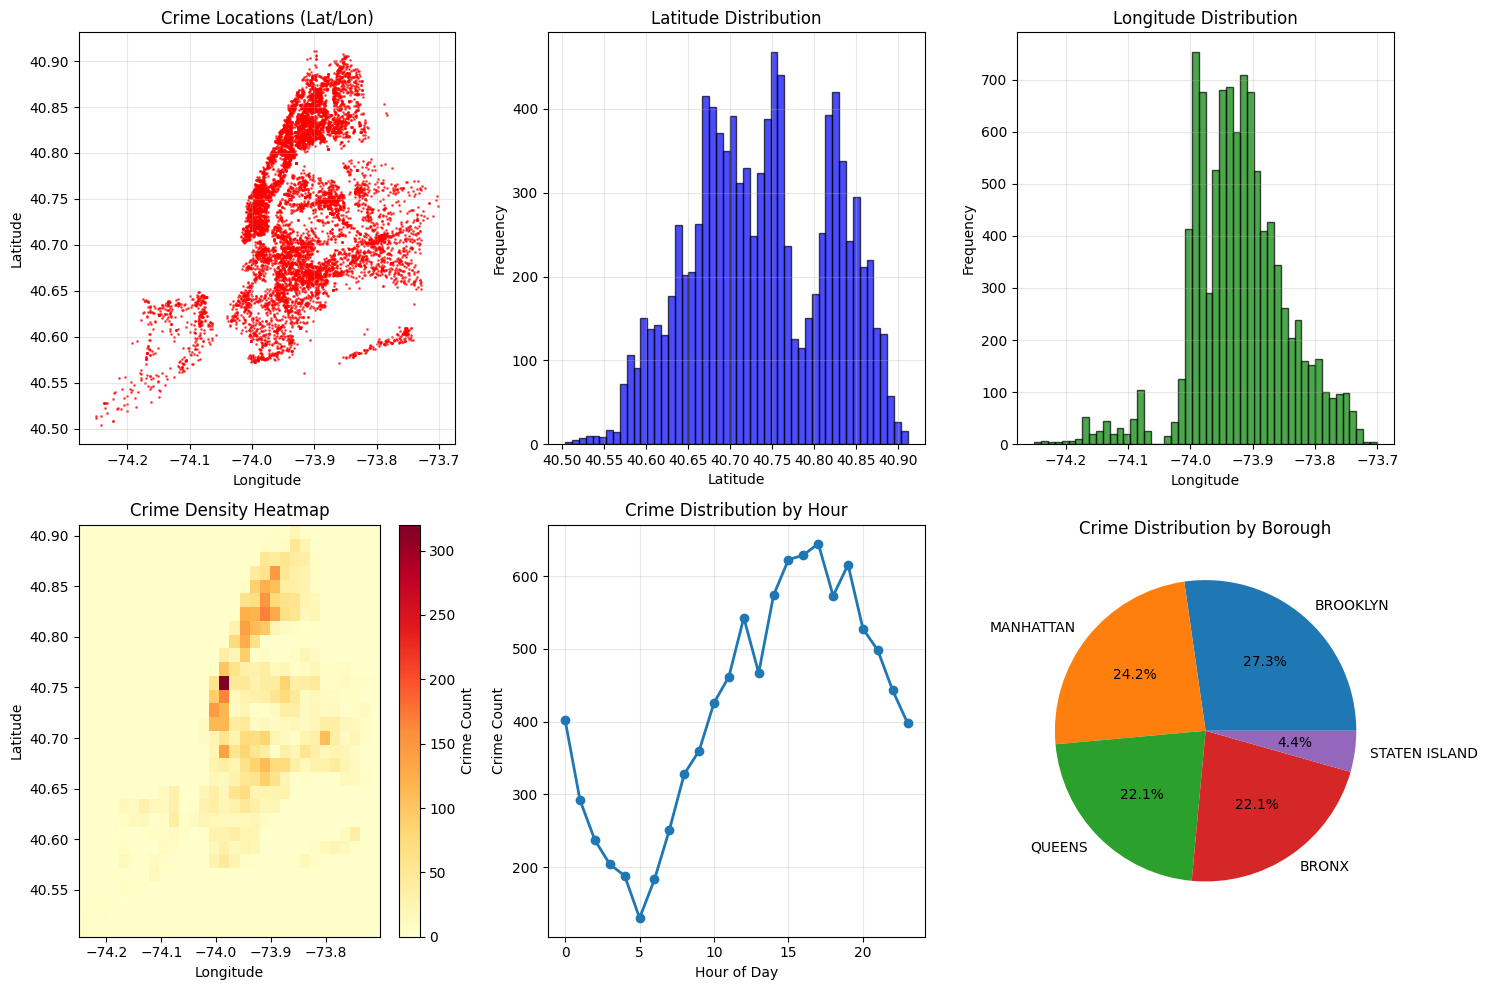


=== Spatial Statistics ===
Latitude range: 40.503406 to 40.910948
Longitude range: -74.250331 to -73.700955
Spatial center: (40.737029, -73.923300)
Spatial std: Lat=0.081803, Lon=0.076753

Potential spatial outliers: 0 latitude, 262 longitude


In [36]:
print("=== Visual Assessment of Spatial Distribution ===")

if available_spatial and len(df_clustering) > 0:
    # Create visualization plots for spatial distribution
    plt.figure(figsize=(15, 10))
    
    # Sample data for visualization if too large
    viz_sample_size = min(10000, len(df_clustering))
    if len(df_clustering) > viz_sample_size:
        df_viz = df_clustering.sample(n=viz_sample_size, random_state=42)
        print(f"Visualizing sample of {viz_sample_size} points (from {len(df_clustering)} total)")
    else:
        df_viz = df_clustering
        print(f"Visualizing all {len(df_viz)} points")
    
    # Subplot 1: Scatter plot of crime locations
    plt.subplot(2, 3, 1)
    plt.scatter(df_viz['Longitude'], df_viz['Latitude'], alpha=0.6, s=1, c='red')
    plt.title('Crime Locations (Lat/Lon)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Latitude distribution
    plt.subplot(2, 3, 2)
    plt.hist(df_viz['Latitude'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Latitude Distribution')
    plt.xlabel('Latitude')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Longitude distribution
    plt.subplot(2, 3, 3)
    plt.hist(df_viz['Longitude'], bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title('Longitude Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: 2D histogram (heatmap)
    plt.subplot(2, 3, 4)
    plt.hist2d(df_viz['Longitude'], df_viz['Latitude'], bins=30, cmap='YlOrRd')
    plt.colorbar(label='Crime Count')
    plt.title('Crime Density Heatmap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Subplot 5: Temporal distribution (if available)
    if 'HOUR' in df_viz.columns:
        plt.subplot(2, 3, 5)
        hourly_counts = df_viz['HOUR'].value_counts().sort_index()
        plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linewidth=2)
        plt.title('Crime Distribution by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Crime Count')
        plt.grid(True, alpha=0.3)
    
    # Subplot 6: Borough distribution (if available)
    if 'BORO_NM' in df_viz.columns:
        plt.subplot(2, 3, 6)
        borough_counts = df_viz['BORO_NM'].value_counts()
        plt.pie(borough_counts.values, labels=borough_counts.index, autopct='%1.1f%%')
        plt.title('Crime Distribution by Borough')
    
    plt.tight_layout()
    plt.show()
    
    # Additional spatial statistics
    print("\n=== Spatial Statistics ===")
    print(f"Latitude range: {df_viz['Latitude'].min():.6f} to {df_viz['Latitude'].max():.6f}")
    print(f"Longitude range: {df_viz['Longitude'].min():.6f} to {df_viz['Longitude'].max():.6f}")
    print(f"Spatial center: ({df_viz['Latitude'].mean():.6f}, {df_viz['Longitude'].mean():.6f})")
    print(f"Spatial std: Lat={df_viz['Latitude'].std():.6f}, Lon={df_viz['Longitude'].std():.6f}")
    
    # Check for potential spatial outliers
    lat_q1, lat_q3 = df_viz['Latitude'].quantile([0.25, 0.75])
    lon_q1, lon_q3 = df_viz['Longitude'].quantile([0.25, 0.75])
    lat_iqr, lon_iqr = lat_q3 - lat_q1, lon_q3 - lon_q1
    
    lat_outliers = ((df_viz['Latitude'] < lat_q1 - 1.5*lat_iqr) | 
                   (df_viz['Latitude'] > lat_q3 + 1.5*lat_iqr)).sum()
    lon_outliers = ((df_viz['Longitude'] < lon_q1 - 1.5*lon_iqr) | 
                   (df_viz['Longitude'] > lon_q3 + 1.5*lon_iqr)).sum()
    
    print(f"\nPotential spatial outliers: {lat_outliers} latitude, {lon_outliers} longitude")
    
else:
    print("No spatial features available for visual assessment.")
